In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms, datasets
from einops import rearrange

### GMM to VAE - 이산분포에서 연속분포로
- 먼저 `Gaussian Mixture Model`의 중간부분에서 논의를 시작해보자. `GMM model`의 `로그가능도`는 `ELBO` 항과 잠재변수의 분포와 `x`가 주어졌을때 `z`의 조건부 분포의 `KL-Div` 항으로 구성되어 있었다. 

- $$ log \, p_{\theta}(x) = ELBO(x;q,\theta) + D_{KL}(q(z)\, ||\, p_{\theta}(z|x)) $$

- 그리고 `ELBO` 항을 풀어쓰게되면 다음과 같다. `ELBO`는 증거하한 항으로, 두번째항인 `KL-Divergence`가 항상 0보다 크기때문에, `로그 가능도`는 항상 `ELBO`보다 크다는 것을 보장할 수 있다는 것도 배웠다.

- $$ ELBO(x;q,\theta) = \sum_{z} q(z)\, log \, \frac{p_{\theta}(x, z)}{q(z)}$$

- `GMM`에서는 `q(z)`라는 임의의 확률분포라는 가정하에 논의를 시작하였지만, `VAE`는 `q(z)`를 정규분포로 제한하게된다. 이에 따라 정규분포의 매개변수인 `mu`와 `Sigma`가 파라미터로 생기게 되는데 이둘을 묶어서 `psi`라고 정한 것이다.

    $ q_{\psi}(z) = N(z; \mu, \Sigma)$

- 그다음 이에 맞게 항을 수정한다.

- $$ log \, p_{\theta}(x) = \int q_{\psi}(z)\, log \, \frac{p_{\theta}(x, z)}{q_{\psi}(z)} dz + D_{KL}(q_{\psi}(z)\, || \, p_{\theta}(z\, |\, x)) $$

    $ \Leftrightarrow log \, p_{\theta}(x) = ELBO(x;\theta, \psi) + D_{KL}(q_{\psi}(z)\, || \, p_{\theta}(z\, |\, x)) $

## VAE (Variational Auto Encoder)

### GMM to VAE - Encoder의 도입

- 근데 여기에 문제가 있다. GMM의 q로 설정한 확률분포의 행렬의 차원이 기억나는가? 그 차원은 (N, k)로, 앞차원이 데이터의 개수가 된다는 것이다. 근데, 데이터가 10억개, 100억개 있으면 N을 10억, 100억으로 만들 수 있을까? 그건 힘들 것이다. 너무나 용량이 커지고, 모든 q를 계산하는데 계산비용이 너무 많이 들것이다.
- 그래서, Encoder를 도입한다. 신경망의 연산을 통해 q의 매개변수인 프사이를 만들어 내도록 하면 이문제를 해결할 수 있다. 이 떄 신경망의 매개변수는 `phi`가 된다. `psi`와 헷갈리지 않도록 주의한다.
- $$ \psi = \{\mu, \sigma\} = NeuralNet(x;\phi) $$
- $$ q_{\phi}(z\,|\,x) = N(z;\mu,\sigma^2I) $$
- sigma는 1차원 벡터이고 이에 항등행렬이 곱해졌으므로 공분산 행렬에는 대각성분만 존재하게 된다. 

### ELBO의 최적화
- 우리는 VAE에서 두번째 항인 KL Divergence는 최적화가 불가능 하므로 ELBO만 최적화한다. 이에 따라 ELBO항을 전개하면 다음과 같다.


    $ ELBO(x;\theta, \psi) $ 
    
    $ = \int q_{\phi}(z\,|\,x)\, log \, \frac{p_{\theta}(x, z)}{q_{\phi}(z)} dz $

    $ = \int q_{\phi}(z\,|\,x)\, log \, \frac{p_{\theta}(x\,|\,z)p(z)}{q_{\phi}(z\,|\,x)} dz $

    $ = \int q_{\phi}(z\,|\,x)\, log \, p_{\theta}(x\,|\,z) dz - \int q_{\phi}(z\,|\,x)\, log \, \frac{q_{\phi}(z\,|\,x)}{p(z)} dz $

    $ = E_{q_{\phi}(z\,|\,x)}[\, log \, p_{\theta}(x\,|\,z)] - D_{KL}(q_{\phi}(z\,|\,x)\,||\,p(z)) $


- 결론만 말하자면, 첫번째 항은 MSE-Error가 되고 뒤쪽의 KL항을 일관성 항으로 잠재 변수의 사후분포 항을 처음에 설정한 변수의 분포와 가깝도록 강제한다.
- MSE-Error와 두 Gaussian 분포사이의 KL-Loss는 익히 알려진 공식들이 있고, 몬테카를로 근사를 통해서 ELBO값을 쉽게 도출할 수 잇다.

- $$ ELBO(x;\theta,\phi) \approx -\frac{1}{2}\sum_{d=1}^{D}{(x_d - \hat{x_d})^2} + \frac{1}{2}\sum_{h=1}^{H}{(1 + log \, \sigma_{h}^2 - \mu_{h}^2 - \sigma_{h}^2)} + const $$

- 여기서, const항과 앞뒤에 달린 0.5가 곱해진 항을 제거하고 부호를 뒤집고 나면, 최종 Loss를 도출할 수 있다.

- $$ LOSS(x;\theta,\phi) \approx \sum_{d=1}^{D}{(x_d - \hat{x_d})^2} - \sum_{h=1}^{H}{(1 + log \, \sigma_{h}^2 - \mu_{h}^2 - \sigma_{h}^2)} $$

#### Encoder

- $ q_{\phi}(z\,|\,x) $ 를 만들어 내는 network이다.
- 입력 차원과 잠재 변수의 차원이 다르다는 점에 주의 한다.

In [2]:
from typing import overload

class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super().__init__()
        self.linear = nn.Linear(input_dim, hidden_dim)
        self.linear_mu = nn.Linear(hidden_dim, latent_dim)
        self.linear_logvar = nn.Linear(hidden_dim, latent_dim)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        h = self.linear(x)
        h = F.relu(h)
        mu = self.linear_mu(h)
        logvar = self.linear_logvar(h)
        sigma = torch.exp(0.5 * logvar)
        return mu, sigma


#### Decoder

- $ p_{\theta}(x\,|\,z) $ 를 만들어 내는 network이다.
- 잠재 벡터를 받아 처음의 입력과 형상이 같은 vector로 복원한다.

In [ ]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super().__init__()
        self.linear1 = nn.Linear(latent_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        h = self.linear1(x)
        h = F.relu(h)
        h = self.linear2(h)
        x_hat = F.sigmoid(h)
        return x_hat

#### VAE클래스 최종 구현
- $ z = \mu + \sigma * \epsilon\, (=N(0, I)) $ 를 수행하는 `reparameterize`메서드가 달려 있다.
- $ LOSS(x;\theta,\phi) \approx \sum_{d=1}^{D}{(x_d - \hat{x_d})^2} - \sum_{h=1}^{H}{(1 + log \, \sigma_{h}^2 - \mu_{h}^2 - \sigma_{h}^2)} $ 를 계산하는 메서드 또한 존재하며, MSE loss와 음의 KL-Divergence의 합으로 구성된다.

In [ ]:
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super().__init__()
        self.encoder = Encoder(input_dim, hidden_dim, latent_dim)
        self.decoder = Decoder(latent_dim, hidden_dim, input_dim)
    
    @classmethod
    def load_from_config(cls, config):
        assert hasattr(config, 'input_dim') and hasattr(config, 'hidden_dim') and hasattr(config, 'latent_dim'), \
            'config must have input_dim, hidden_dim, and latent_dim attributes'
        return cls(config.input_dim, config.hidden_dim, config.latent_dim)

    def get_loss(self, x: torch.Tensor) -> torch.Tensor:
        mu, sigma = self.encoder(x)
        z = self.reparametrize(mu, sigma)
        x_hat = self.decoder(z)

        batch_size = len(x)
        L1 = F.mse_loss(x_hat, x, reduction='sum')
        L2 = - torch.sum(1 + torch.log(sigma**2) - mu**2 - sigma**2)
        return (L1 + L2) / batch_size
    
    @staticmethod
    def reparametrize(mu, sigma):
        eps = torch.randn_like(sigma)
        return mu + sigma * eps

- config는 따로 정의해서 hyper parameter를 잘보이게 해주자.

In [7]:
class ModelConfigs:
    input_dim = 784
    hidden_dim = 400
    latent_dim = 20

class TrainConfigs:
    batch_size = 32
    epochs = 30
    learning_rate = 3e-4

## Training VAE
- train 함수를 먼저 정의해준다.

In [15]:
def train(model: VAE, optimizer, dataloader, epochs, device):
    losses = []
    for epoch in range(epochs):
        loss_sum = 0
        cnt = 0
        for x, label in dataloader:
            x = x.to(device)
            label = label.to(device)
            optimizer.zero_grad()
            loss = model.get_loss(x)
            loss.backward()
            optimizer.step()

            loss_sum += loss.item()
            cnt += 1
        loss_avg = loss_sum / cnt
        losses.append(loss_avg)
        print(f'Epoch {epoch+1}/{epochs}, loss={loss_avg}')
    return losses

- einops.. 최신기술도 한번 써주고..

In [ ]:
# load_configs

model_cfg = ModelConfigs()
train_cfg = TrainConfigs()

# ready dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: rearrange(x, 'c h w -> (c h w)'))
])

# MNIST dataset
dataset = datasets.MNIST(root='data', train=True, transform=transform, download=True)

# Data loader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=train_cfg.batch_size, shuffle=True)

# ready model
model = VAE.load_from_config(model_cfg)
optimizer = torch.optim.Adam(model.parameters(), lr=train_cfg.learning_rate)

# device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


VAE(
  (encoder): Encoder(
    (linear): Linear(in_features=784, out_features=400, bias=True)
    (linear_mu): Linear(in_features=400, out_features=20, bias=True)
    (linear_logvar): Linear(in_features=400, out_features=20, bias=True)
  )
  (decoder): Decoder(
    (linear1): Linear(in_features=20, out_features=400, bias=True)
    (linear2): Linear(in_features=400, out_features=784, bias=True)
  )
)

In [17]:
losses = train(model, optimizer, dataloader, train_cfg.epochs, device)

Epoch 1/30, loss=50.40081544189453
Epoch 2/30, loss=43.804915047200524
Epoch 3/30, loss=42.28577856241862
Epoch 4/30, loss=41.33989190470378
Epoch 5/30, loss=40.79989707845052
Epoch 6/30, loss=40.4068250386556
Epoch 7/30, loss=40.153462223307294
Epoch 8/30, loss=39.93258985087077
Epoch 9/30, loss=39.77225394083659
Epoch 10/30, loss=39.60616960652669
Epoch 11/30, loss=39.468654325358074
Epoch 12/30, loss=39.340337858072914
Epoch 13/30, loss=39.3043380472819
Epoch 14/30, loss=39.14922585652669
Epoch 15/30, loss=39.065233959960935
Epoch 16/30, loss=39.011169181315104
Epoch 17/30, loss=38.89522243448893
Epoch 18/30, loss=38.8245639851888
Epoch 19/30, loss=38.7698800415039
Epoch 20/30, loss=38.706513217163085
Epoch 21/30, loss=38.63755681355794
Epoch 22/30, loss=38.59098448689779
Epoch 23/30, loss=38.548699678548175
Epoch 24/30, loss=38.48776643981934
Epoch 25/30, loss=38.37572187906901
Epoch 26/30, loss=38.387880005900065
Epoch 27/30, loss=38.321073834228514
Epoch 28/30, loss=38.2867841389

## Loss Visualization

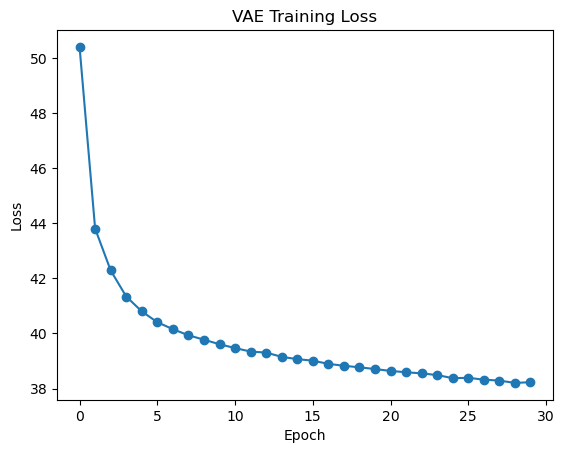

In [18]:
plt.title("VAE Training Loss")
plt.plot(losses)
plt.scatter(range(len(losses)), losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.savefig('./result_images/vae_loss.png')
plt.show()

## Image Generation

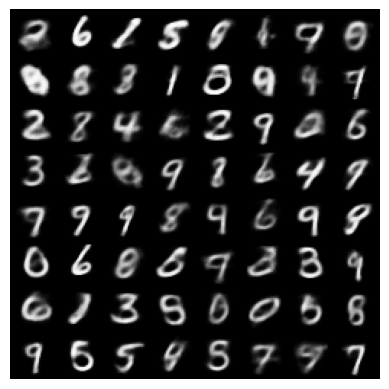

In [19]:
with torch.no_grad():
    sample_size = 64
    z = torch.randn(sample_size, model_cfg.latent_dim).to(device)
    x = model.decoder(z)
    generated_images = x.view(sample_size, 1, 28, 28)

grid_img = torchvision.utils.make_grid(generated_images, nrow=8, padding=2, normalize=True)
grid_img = grid_img.permute(1, 2, 0).cpu().numpy()

plt.clf()
plt.imshow(grid_img)
plt.axis('off')
plt.savefig('./result_images/vae_generated_images.png')
plt.show()